#### Zadanie 1 (6pkt):

Zadanie polega na wykonaniu rozsądnej ilości testów dotyczących różnej ilości warstw ukrytych i różnej ilości neuronów w tych warstwach. Posługujemy się profesjonalną implementacją sieci MLP, np.  z sklearn. Ponadto należy przetestować różne ilości iteracji, regularyzacje oraz wykonać wizualizacje dokładności i błędu funkcji kosztu dla kolejnych iteracji.

In [38]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

import sys
import subprocess
import pkg_resources
import numpy as np

from tqdm import tqdm


required = {'scikit-image'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing: 
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

def load_train_data(input_dir, newSize=(64,64)):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib
    
    image_dir = Path(input_dir)
    categories_name = []
    for file in os.listdir(image_dir):
        d = os.path.join(image_dir, file)
        if os.path.isdir(d):
            categories_name.append(file)

    folders = [directory for directory in image_dir.iterdir() if directory.is_dir()]

    train_img = []
    categories_count=[]
    labels=[]
    for i, direc in enumerate(folders):
        count = 0
        for obj in direc.iterdir():
            if os.path.isfile(obj) and os.path.basename(os.path.normpath(obj)) != 'desktop.ini':
                labels.append(os.path.basename(os.path.normpath(direc)))
                count += 1
                img = imread(obj)#zwraca ndarry postaci xSize x ySize x colorDepth
                img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
                img = img / 255#normalizacja
                train_img.append(img)
        categories_count.append(count)
    X={}
    X["values"] = np.array(train_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

def load_test_data(input_dir, newSize=(64,64)):
    import numpy as np
    import pandas as pd
    import os
    from skimage.io import imread
    import cv2 as cv
    from pathlib import Path
    import random
    from shutil import copyfile, rmtree
    import json

    import seaborn as sns
    import matplotlib.pyplot as plt

    import matplotlib

    image_path = Path(input_dir)

    labels_path = image_path.parents[0] / 'test_labels.json'

    jsonString = labels_path.read_text()
    objects = json.loads(jsonString)

    categories_name = []
    categories_count=[]
    count = 0
    c = objects[0]['value']
    for e in  objects:
        if e['value'] != c:
            categories_count.append(count)
            c = e['value']
            count = 1
        else:
            count += 1
        if not e['value'] in categories_name:
            categories_name.append(e['value'])

    categories_count.append(count)
    
    test_img = []

    labels=[]
    for e in objects:
        p = image_path / e['filename']
        img = imread(p)#zwraca ndarry postaci xSize x ySize x colorDepth
        img = cv.resize(img, newSize, interpolation=cv.INTER_AREA)# zwraca ndarray
        img = img / 255#normalizacja
        test_img.append(img)
        labels.append(e['value'])

    X={}
    X["values"] = np.array(test_img)
    X["categories_name"] = categories_name
    X["categories_count"] = categories_count
    X["labels"]=labels
    return X

def get_dataset(new_size=64):
    data_train = load_train_data("train_test_sw/train_sw", newSize=(new_size,new_size))
    X_train = data_train['values']
    y_train = data_train['labels']

    data_test = load_test_data("train_test_sw/test_sw", newSize=(new_size,new_size))
    X_test = data_test['values']
    y_test = data_test['labels']

    class_le = LabelEncoder()
    y_train_enc = class_le.fit_transform(y_train)
    y_test_enc = class_le.fit_transform(y_test)

    X_train = X_train.flatten().reshape(X_train.shape[0], int(np.prod(X_train.shape) / X_train.shape[0]))
    X_test = X_test.flatten().reshape(X_test.shape[0], int(np.prod(X_test.shape) / X_test.shape[0]))

    return X_train, y_train_enc, X_test, y_test_enc

def test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes, alpha, max_iter):
    mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha, max_iter=max_iter)
    accuracy = []

    result = {
        'num_layers': len(hidden_layer_sizes),
        'layer_sizes': hidden_layer_sizes,
        'regularization': alpha,
        'max_iter': max_iter
    }

    for i in tqdm(range(max_iter)):
        mlp.partial_fit(X_train, y_train, np.unique(y_train))
        accuracy.append(mlp.score(X_train, y_train))
        if i == 50:
            result['checkpoint_train_accuracy'] = np.mean(accuracy)
            result['checkpoint_val_accuracy'] = mlp.score(X_val, y_val)
            result['checkpoint_test_accuracy'] = mlp.score(X_test, y_test)

    result['full_train_accuracy'] = np.mean(accuracy)
    result['full_val_accuracy'] = mlp.score(X_val, y_val)
    result['full_test_accuracy'] = mlp.score(X_test, y_test)
    result['accuracy_curve'] = accuracy
    result['loss_curve'] = mlp.loss_curve_

    return result

def print_result(result):
    print(f"NUMBER OF HIDDEN LAYERS = {result['num_layers']}")
    print(f"HIDDEN LAYER SIZES = {result['layer_sizes']}")
    print(f"REGULARIZATION = {result['regularization']}")
    print("\n50 EPOCHS")
    print(f"train_accuracy = {round(result['checkpoint_train_accuracy'] * 100, 2)}%")
    print(f"val_accuracy = {round(result['checkpoint_val_accuracy'] * 100, 2)}%")
    print(f"test_accuracy = {round(result['checkpoint_test_accuracy'] * 100, 2)}%")
    print(f"\n{result['max_iter']} EPOCHS")
    print(f"train_accuracy = {round(result['full_train_accuracy'] * 100, 2)}%")
    print(f"val_accuracy = {round(result['checkpoint_val_accuracy'] * 100, 2)}%")
    print(f"test_accuracy = {round(result['full_test_accuracy'] * 100, 2)}%")

def get_plot(result):
    f = plt.figure(figsize=(12,6))
    plt.plot(result['loss_curve'], label='loss')
    plt.plot(result['accuracy_curve'], label='accuracy')
    plt.legend(loc='best')
    plt.xlabel('number of iterations')
    plt.grid()
    plt.show()



In [2]:
from sklearn.model_selection import train_test_split

NEW_SIZE = 64

ONE_LAYER = (286,)
TWO_LAYERS = (437, 46)
THREE_LAYERS = (2166, 286, 38)


X_train, y_train, X_test, y_test = get_dataset(new_size=NEW_SIZE)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

all_results = []

In [4]:
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=ONE_LAYER, alpha=0.1, max_iter=200))
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=ONE_LAYER, alpha=0.001, max_iter=200))

100%|██████████| 200/200 [04:01<00:00,  1.21s/it]


In [5]:
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=TWO_LAYERS, alpha=0.1, max_iter=200))
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=TWO_LAYERS, alpha=0.001, max_iter=200))

100%|██████████| 200/200 [05:19<00:00,  1.60s/it]


In [7]:
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=THREE_LAYERS, alpha=0.01, max_iter=200))
all_results.append(test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=THREE_LAYERS, alpha=0.001, max_iter=200))

100%|██████████| 200/200 [44:00<00:00, 13.20s/it]


In [40]:
# TODO błąd przy regularyzacji
all_results[4] = test_mlp(X_train, y_train, X_val, y_val, X_test, y_test, hidden_layer_sizes=THREE_LAYERS, alpha=0.1, max_iter=200)

100%|██████████| 200/200 [46:41<00:00, 14.01s/it]


NUMBER OF HIDDEN LAYERS = 1
HIDDEN LAYER SIZES = (286,)
REGULARIZATION = 0.1

50 EPOCHS
train_accuracy = 70.72%
val_accuracy = 61.54%
test_accuracy = 71.81%

200 EPOCHS
train_accuracy = 87.68%
val_accuracy = 61.54%
test_accuracy = 70.27%


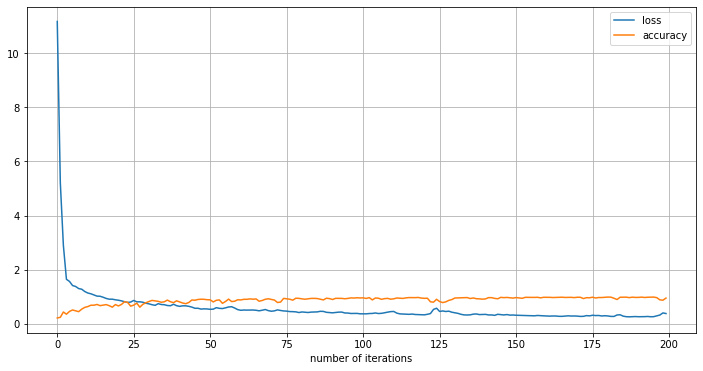

NUMBER OF HIDDEN LAYERS = 1
HIDDEN LAYER SIZES = (286,)
REGULARIZATION = 0.001

50 EPOCHS
train_accuracy = 63.91%
val_accuracy = 59.62%
test_accuracy = 68.34%

200 EPOCHS
train_accuracy = 86.05%
val_accuracy = 59.62%
test_accuracy = 77.99%


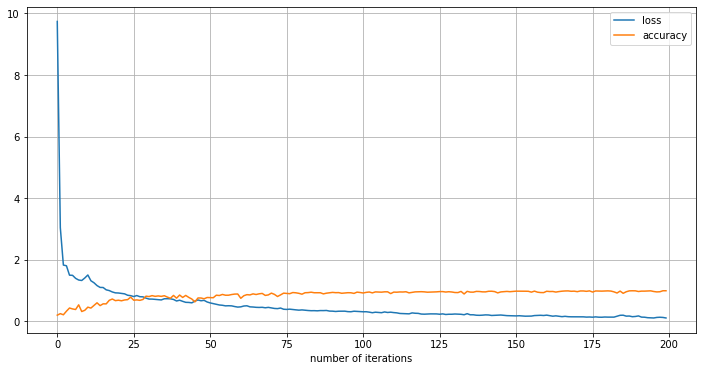

NUMBER OF HIDDEN LAYERS = 2
HIDDEN LAYER SIZES = (437, 46)
REGULARIZATION = 0.1

50 EPOCHS
train_accuracy = 66.85%
val_accuracy = 67.31%
test_accuracy = 68.34%

200 EPOCHS
train_accuracy = 84.63%
val_accuracy = 67.31%
test_accuracy = 75.29%


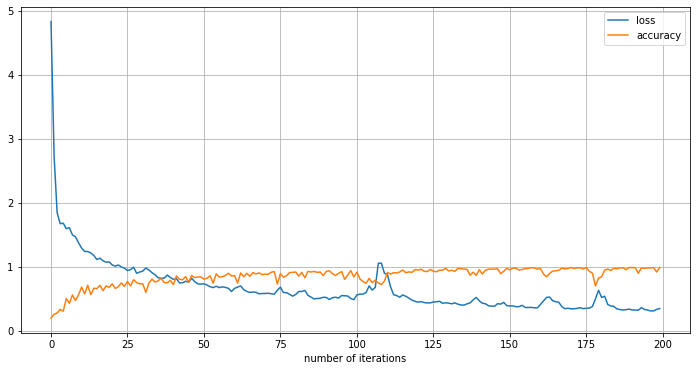

NUMBER OF HIDDEN LAYERS = 2
HIDDEN LAYER SIZES = (437, 46)
REGULARIZATION = 0.001

50 EPOCHS
train_accuracy = 64.22%
val_accuracy = 61.54%
test_accuracy = 72.59%

200 EPOCHS
train_accuracy = 86.25%
val_accuracy = 61.54%
test_accuracy = 78.76%


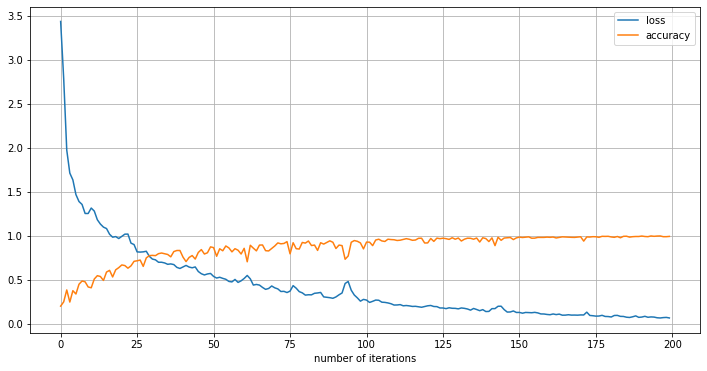

NUMBER OF HIDDEN LAYERS = 3
HIDDEN LAYER SIZES = (2166, 286, 38)
REGULARIZATION = 0.1

50 EPOCHS
train_accuracy = 56.48%
val_accuracy = 59.62%
test_accuracy = 64.48%

200 EPOCHS
train_accuracy = 76.48%
val_accuracy = 59.62%
test_accuracy = 77.61%


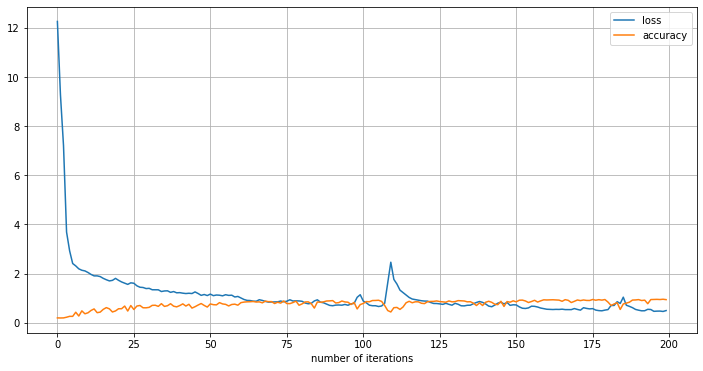

NUMBER OF HIDDEN LAYERS = 3
HIDDEN LAYER SIZES = (2166, 286, 38)
REGULARIZATION = 0.001

50 EPOCHS
train_accuracy = 56.51%
val_accuracy = 57.69%
test_accuracy = 67.57%

200 EPOCHS
train_accuracy = 83.33%
val_accuracy = 57.69%
test_accuracy = 76.83%


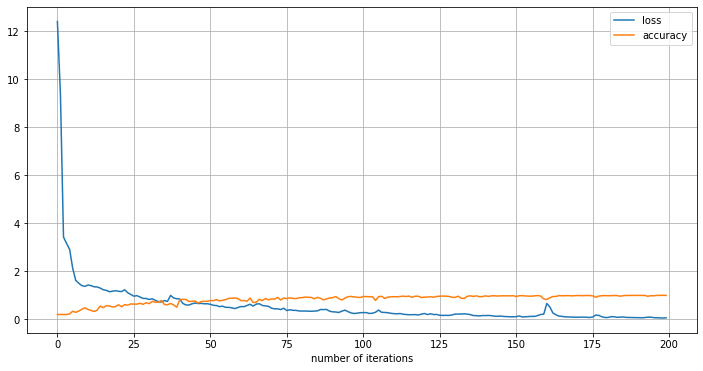

In [41]:
for result in all_results:
    print_result(result)
    get_plot(result)

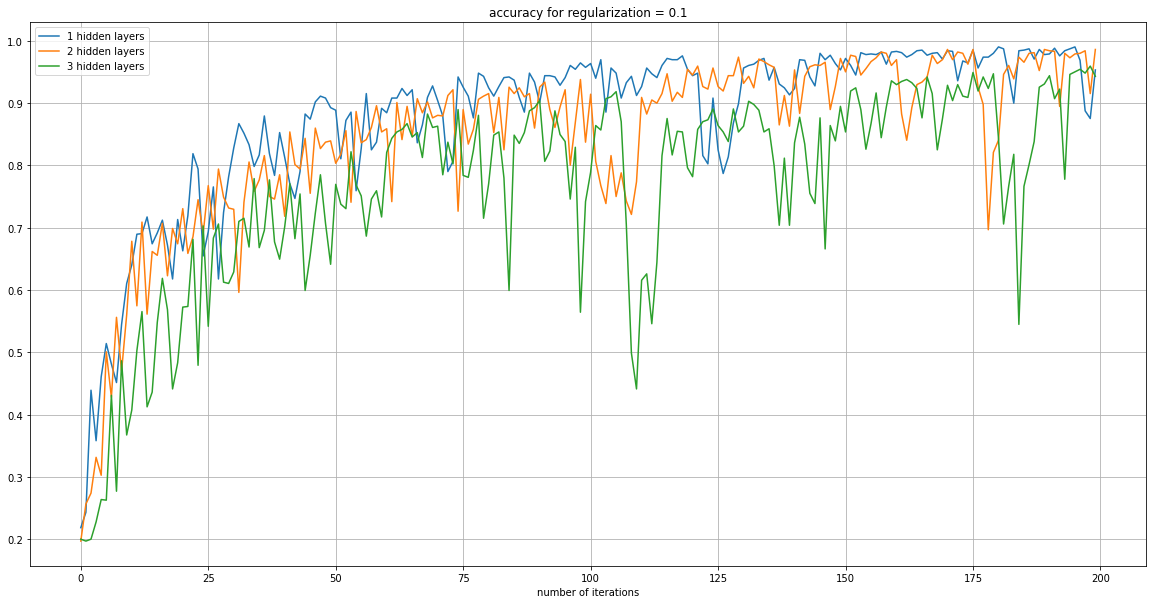

In [42]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(10)

for result in all_results:
    if result['regularization'] == 0.1:
        plt.plot(result['accuracy_curve'], label=f"{result['num_layers']} hidden layers")

plt.legend(loc='best')
plt.xlabel('number of iterations')
plt.title('accuracy for regularization = 0.1')
plt.grid()
plt.show()

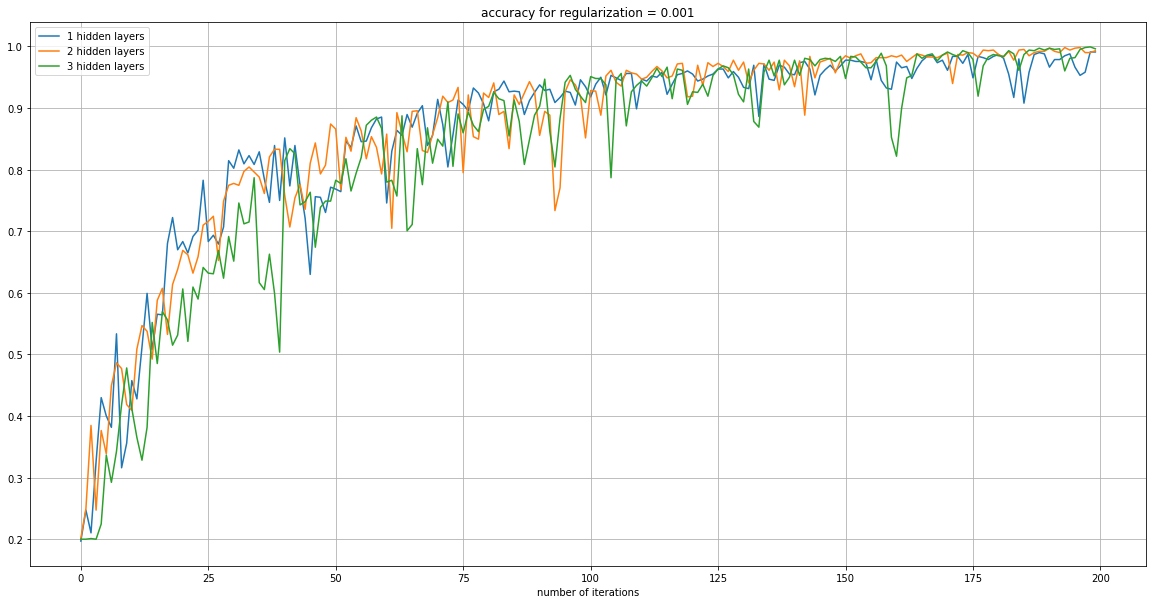

In [43]:
f = plt.figure(figsize=(20,10))
f.set_figwidth(20)
f.set_figheight(10)

for result in all_results:
    if result['regularization'] == 0.001:
        plt.plot(result['accuracy_curve'], label=f"{result['num_layers']} hidden layers")

plt.legend(loc='best')
plt.xlabel('number of iterations')
plt.title('accuracy for regularization = 0.001')
plt.grid()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


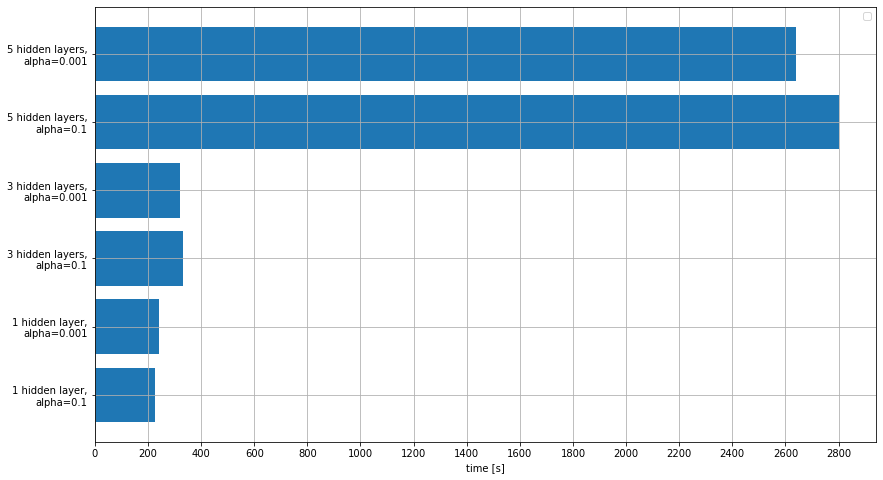

In [46]:
data = {
    '1 hidden layer,\nalpha=0.1' : 226,
    '1 hidden layer,\nalpha=0.001' : 241,
    '3 hidden layers,\nalpha=0.1' : 331,
    '3 hidden layers,\nalpha=0.001' : 319,
    '5 hidden layers,\nalpha=0.1' : 2801,
    '5 hidden layers,\nalpha=0.001' : 2640
}

f = plt.figure(figsize=(14,8))

plt.barh(list(data.keys()), list(data.values()))

plt.legend(loc='best')
plt.xlabel('time [s]')
plt.xticks(np.arange(0, 2900, step=200))
plt.grid()
plt.show()

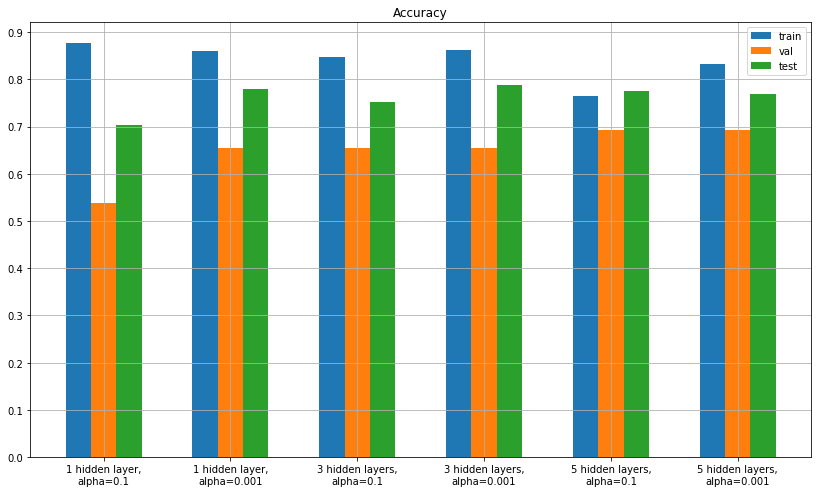

In [53]:
f = plt.figure(figsize=(14,8))

X_axis = np.arange(len(list(data.keys())))

Ytrain = [result['full_train_accuracy'] for result in all_results]
Yval = [result['full_val_accuracy'] for result in all_results]
Ytest = [result['full_test_accuracy'] for result in all_results]

plt.bar(X_axis - 0.2, Ytrain, 0.2, label='train')
plt.bar(X_axis, Yval, 0.2, label='val')
plt.bar(X_axis + 0.2, Ytest, 0.2, label='test')

plt.xticks(X_axis, list(data.keys()))
plt.yticks(np.arange(0, 1, step=0.1))
plt.legend(loc='best')
plt.title('Accuracy')
plt.grid()
plt.show()